<a href="https://colab.research.google.com/github/oceam/agri-image/blob/main/codes/areacal_robo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# step1 download image

In [17]:
!gdown --id 1ZTKUhvqAIFh1HlJtSoMC800J5hvi_NUA

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZTKUhvqAIFh1HlJtSoMC800J5hvi_NUA
To: /content/rice stem prediction.v6i.yolov8.zip
100% 60.4M/60.4M [00:03<00:00, 19.4MB/s]


#step2 unzip image, prepare result folder

In [25]:
!mkdir /content/rawdata
!mkdir /content/results/test
!mkdir /content/results/train
!mkdir /content/results/val

mkdir: cannot create directory ‘/content/rawdata’: File exists


In [ ]:
!unzip '/content/rice stem prediction.v6i.yolov8.zip' -d '/content/rawdata/'

#step3 check the annotation

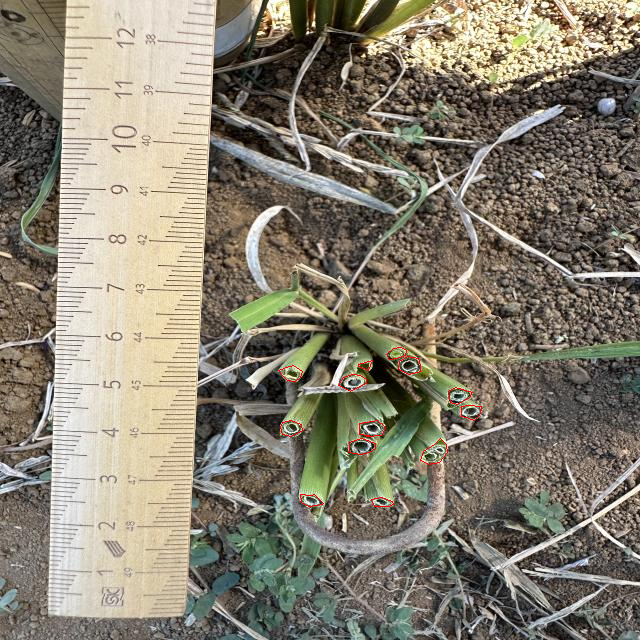

In [14]:
from PIL import Image, ImageDraw
from IPython.display import display

def draw_yolo_segmentation(image_path, annotation_content):
    # Load the image
    with Image.open(image_path) as img:
        draw = ImageDraw.Draw(img)
        width, height = img.size

        # Iterate through each annotation line
        for line in annotation_content:
            # Parse the line to get class_id and polygon points
            parts = line.strip().split()
            points = list(map(float, parts[1:]))  # Skip the class_id
            polygon = [(points[i] * width, points[i + 1] * height) for i in range(0, len(points), 2)]

            # Draw polygon
            draw.polygon(polygon, outline="red")

        # Return the image object
        return img

# Read the annotation file
with open('/content/12_0901G1_JPG.rf.e629b77680547bcf3f4a8a2b3cd80fe1.txt', 'r') as file:
    annotation_content = file.readlines()

# Call the function and display the image
example_image_path = '/content/12_0901G1_JPG.rf.e629b77680547bcf3f4a8a2b3cd80fe1.jpg'
annotated_img = draw_yolo_segmentation(example_image_path, annotation_content)
display(annotated_img)


#step4 read all image and annotation file, calculate area, save to csv

In [24]:
from PIL import Image, ImageDraw
import csv
import numpy as np
import os

def calculate_polygon_area(img, polygon):
    """Calculate the area of a polygon by counting the number of pixels within it."""
    mask = Image.new('L', (img.width, img.height), 0)
    ImageDraw.Draw(mask).polygon(polygon, outline=1, fill=1)
    mask = np.array(mask)
    return np.sum(mask)

def process_image(image_path, label_path, output_image_path, output_csv_path):
    # Load the image
    with Image.open(image_path) as img:
        draw = ImageDraw.Draw(img)

        # Prepare data for CSV
        csv_data = [['Class ID', 'Area (pixels)']]

        # Read the annotation file
        with open(label_path, 'r') as file:
            annotation_content = file.readlines()

        # Iterate through each annotation line
        for line in annotation_content:
            # Parse the line to get class_id and polygon points
            parts = line.strip().split()
            class_id = int(parts[0])
            points = list(map(float, parts[1:]))
            polygon = [(points[i] * img.width, points[i + 1] * img.height) for i in range(0, len(points), 2)]

            # Draw polygon and calculate area
            draw.polygon(polygon, outline="red")
            area = calculate_polygon_area(img, polygon)
            csv_data.append([class_id, area])

        # Save annotated image
        img.save(output_image_path)

        # Save CSV file
        with open(output_csv_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(csv_data)

# Directories
image_dir = '/content/rawdata/test/images'
label_dir = '//content/rawdata/test/labels'
result_dir = '/content/results/test'

# Create result directory if it doesn't exist
os.makedirs(result_dir, exist_ok=True)

# Process each image
for image_file in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')
    output_image_path = os.path.join(result_dir, 'annotated_' + image_file)
    output_csv_path = os.path.join(result_dir, os.path.splitext(image_file)[0] + '_areas.csv')

    if os.path.exists(label_path):
        process_image(image_path, label_path, output_image_path, output_csv_path)
    else:
        print(f"No label file found for {image_file}")
